# PyTorchとSciPyの両方でSTFTを実行してみる

- 2020-07-25

勉強のため PyToch と SciPy で同条件を指定した STFT を実行する。

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal
import torch

%matplotlib inline

# 信号を生成

振幅10周波数1.5kHzの余弦波と、振幅15周波数500Hzの正弦波を足し合わせた信号をサンプリング周波数4096Hzで採取した（かのような）信号を生成する。

torch.Size([4096])
min: tensor(-23.2636, dtype=torch.float64)
max: tensor(23.2636, dtype=torch.float64)


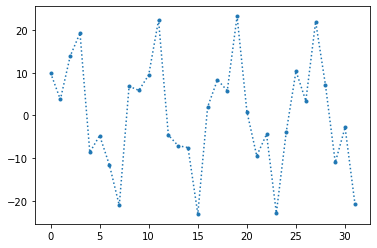

In [2]:
dt0 = datetime(2020, 1, 1, 0, 0, 0)

t = torch.arange(4096, dtype=torch.float64)
X = (
    10 * torch.cos(1500 * t / (4096 / np.pi / 2)) +
    15 * torch.sin(500 * t / (4096 / np.pi / 2))
)
print(X.shape)

print("min:", min(X))
print("max:", max(X))

fix, ax = plt.subplots(1, 1)
ax.plot(t[:32], X[:32], ".:")
plt.show()

# PyTorch で STFT を実行

サンプリング周波数4096Hzを前提に、ウィンドウサイズ256サンプル、ホップサイズを128サンプルとして実行。ウィンドウ両外側は定数0であるとして処理。`torch.stft()` が返すテンソルの軸は、(1)バッチ（入力が(バッチ×時間)なテンソルならば）、(2)周波数、(3)時間、および(4)複素数の実数成分か虚数成分か、となる。最後の成分は絶対値に落とし、ステレオグラム描画に進む。

In [3]:
window = torch.hann_window(256)

In [4]:
%%time
y = torch.stft(  # (freq, time, real/image)
    X,
    n_fft=4096,
    window=window,
    win_length=256,
    hop_length=128,
    center=True,
    pad_mode="constant",
)
y = torch.norm(y, dim=2)  # (freq, time)

CPU times: user 33.7 ms, sys: 166 µs, total: 33.9 ms
Wall time: 8.59 ms


y.shape: torch.Size([2049, 33])


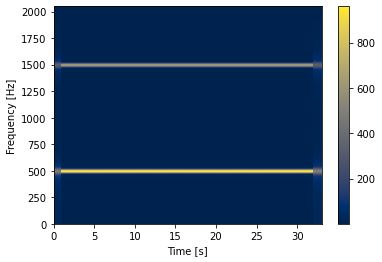

In [5]:
print("y.shape:", y.shape)

fig, ax = plt.subplots(1, 1)
ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Time [s]")
mesh = ax.pcolormesh(y, cmap="cividis")
fig.colorbar(mesh)
plt.show()

# SciPyでSTFTをする

PyTorchでやった処理と同じことを行う。なお計算結果は複素数で返ってくるものの PyTorch と異なり Python の複素数型で表現される（テンソルの次元が一つ少ないのはそのため）。これも絶対値に落としてステレオグラム描画に進む。

In [6]:
%%time
ff, tt, Zyy = scipy.signal.stft(
    X,
    fs=4096,
    nfft=4096,
    nperseg=256,
    noverlap=128,
    boundary="zeros",
    padded=True,
)
yy = np.abs(Zyy)

CPU times: user 3.62 ms, sys: 0 ns, total: 3.62 ms
Wall time: 2.92 ms


yy.shape: (2049, 33)
ff: 0.0 2048.0
tt: 0.0 1.0


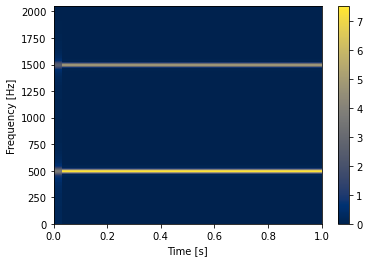

In [7]:
print("yy.shape:", yy.shape)
print("ff:", min(ff), max(ff))
print("tt:", min(tt), max(tt))

fig, ax = plt.subplots(1, 1)
ax.set_ylabel("Frequency [Hz]")
ax.set_xlabel("Time [s]")
mesh = ax.pcolormesh(tt, ff, yy, vmin=0, cmap="cividis")
fig.colorbar(mesh)
plt.show()

# 計算結果を確認

算出された結果を比較。ほぼ完璧に一致していることが確認できる（グラフの縦軸スケールが非常に小さいことに注意）。

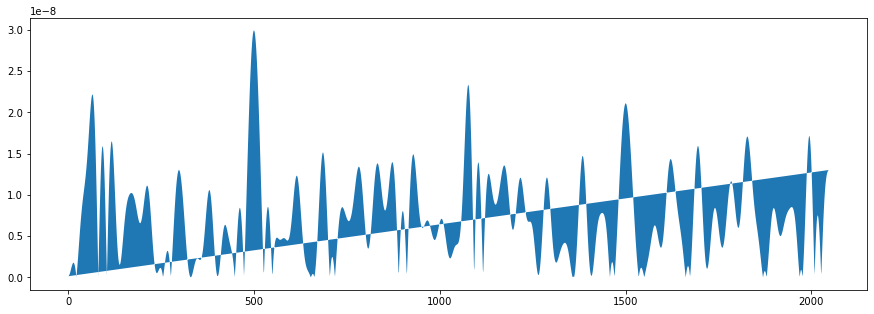

In [8]:
def plot_standardized_difference(y, yy):
    # [0, 1]の範囲に収まるよう標準化する
    y = np.asarray(y)
    y -= np.min(y)
    y /= np.max(y)
    yy = np.asarray(yy)
    yy -= np.min(yy)
    yy /= np.max(yy)

    # 差を計算してプロット
    # （全時点において同じ差異になっていたため最初ひとつだけ）
    diff = np.abs(y - yy)
    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    ax.fill(diff[:, 0])
    plt.show()

plot_standardized_difference(y, yy)